# CS 109A/STAT 121A/AC 209A/CSCI E-109A

## Standard Section 5: Partial Components Analysis (PCA) Fitting and Model Selection

**Harvard University**<br/>
**Fall 2017**<br/>
**Section Leaders: Albert Wu, Nathaniel Burbank<br/>**
**Instructors: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine** 

<center>**Download this notebook from the CS109 repo or here:**</center>
<center>**http://bit.ly/109_S5**</center>

For this section, our goal is to review and further our understanding of the Partial Components Analysis (PCA) model. PCA is highly effective in applications to high dimensionional datasets, which we will use here. Specifically, this section is designed to help us answer Homework 4, part (h). 

Specifically, we will: 
    
    1. Review the basics of Partial Components Analysis and hone our intution
    2. Discuss implementation of PCA within Python and coding issues to keep in mind
    3. Use the principles of model selection we have learned in lecture to find a "best" PCA feature set.
    4. Compare our PCA model with other models we have fit in labs and lecture and discuss coefficient meanings.


For this section we will be using the following packages:

In [66]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
# Note --  Requires sklearn version .18 or higher  

from sklearn import metrics, datasets
from collections import Counter
import statsmodels.formula.api as sm
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
sns.set(style="ticks")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

assert(sys.version_info.major==3),print(sys.version)
# Python 3 or higher is required

## Part (1): Load in our data and fit the PCA model


We will first load in our dataset below and look at the first few rows. Then, we use the describe function to get a sense of the data.

In [78]:
crime_df = pd.read_csv('Crime.csv').drop('Date', axis=1)
crime_df.head()

,Incidence,Temp,Dewpoint,Windspeed,Pressure,Precipitation,TMAX_C,TMIN_C,Year,Month,DOW,Weekend,Season
0,182,26.444444,15.944444,8.5,1008.5,0.0,31.722222,21.722222,2012,7,Sunday,1,Summer
1,295,24.333333,9.666667,7.9,1012.2,0.0,31.722222,20.000000,2012,7,Monday,0,Summer
2,267,22.722222,9.666667,5.5,1016.0,0.0,28.888889,18.277778,2012,7,Tuesday,0,Summer
3,250,23.166667,14.500000,6.7,1020.1,0.0,28.277778,18.277778,2012,7,Wednesday,0,Summer
4,259,24.500000,15.611111,8.6,1021.3,0.0,30.000000,18.888889,2012,7,Thursday,0,Summer


In [79]:
crime_df.describe()

,Incidence,Temp,Dewpoint,Windspeed,Pressure,Precipitation,TMAX_C,TMIN_C,Year,Month,Weekend
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,238.107763,10.583815,3.713090,9.168767,1016.463562,0.114913,16.309082,5.841755,2013.515068,6.526027,0.285845
std,31.539843,9.913817,10.848571,3.269969,7.632274,0.303409,10.445645,9.806276,0.957746,3.449427,0.452022
min,115.000000,-14.222222,-24.277778,2.200000,987.400000,0.000000,-10.000000,-19.388889,2012.000000,1.000000,0.000000
25%,219.000000,2.500000,-4.055556,6.900000,1011.300000,0.000000,7.222222,-1.111111,2013.000000,4.000000,0.000000
50%,240.000000,11.333333,4.722222,8.700000,1016.400000,0.000000,17.222222,6.722222,2014.000000,7.000000,0.000000
75%,259.000000,19.111111,12.888889,11.000000,1021.400000,0.055000,25.611111,15.000000,2014.000000,10.000000,1.000000
max,349.000000,30.944444,22.444444,25.800000,1040.400000,3.540000,37.222222,26.111111,2015.000000,12.000000,1.000000


Convert the columns that are categorical variables into dummy variables.

In [80]:
categorical_columns = ['Year', 'Month', 'Weekend', 'Season', 'DOW']
numerical_columns = ['Incidence', 'Temp', 'Dewpoint', 'Windspeed', 'Pressure', 'Precipitation', 'TMAX_C', 'TMIN_C']
crime_df = pd.get_dummies(crime_df, columns=categorical_columns, drop_first=True)

Now, let's split this dataset up into a testing and training set.

In [81]:
train, test =  train_test_split(crime_df, test_size=.2, random_state=123)
train.shape,test.shape

((876, 32), (219, 32))

Now let us standarize the numerical variables only.

In [82]:
mean = train[numerical_columns].mean()
std = train[numerical_columns].std()

mean_t = test[numerical_columns].mean()
std_t = test[numerical_columns].std()

train[numerical_columns] = (train[numerical_columns] - mean)/std
test[numerical_columns] = (test[numerical_columns] - mean_t)/std_t

Now to let us subset and create convenient formats for parts in train and test

In [91]:
all_predictors = ['Temp','Dewpoint','Windspeed','Pressure','Precipitation','TMAX_C','TMIN_C','Year_2013','Year_2014','Year_2015','Month_2','Month_3','Month_4','Month_5','Month_6','Month_7','Month_8','Month_9','Month_10','Month_11','Month_12','Weekend_1','Season_Spring','Season_Summer','Season_Winter','DOW_Monday','DOW_Saturday','DOW_Sunday','DOW_Thursday','DOW_Tuesday','DOW_Wednesday']

X_train_df = train[all_predictors]
X_test_df  = test[all_predictors]
X_train_np = train[all_predictors].values
X_test_np  = test[all_predictors].values
y_train = train['Incidence'].values
y_test = test['Incidence'].values

In [112]:
pca = PCA(n_components=31)
pca.fit(X_train_np)
train_pca = pca.transform(X_train_np)
test_pca = pca.transform(X_test_np)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [  4.23102231e-01   1.55636568e-01   7.88115360e-02   5.75802443e-02
   3.60898297e-02   3.34295097e-02   3.17524515e-02   2.13091889e-02
   1.64031327e-02   1.49251832e-02   1.46249090e-02   1.43912552e-02
   1.39613947e-02   1.33238368e-02   9.38209378e-03   8.98097315e-03
   8.60761929e-03   8.37845137e-03   8.25295260e-03   7.93921559e-03
   7.47373518e-03   4.94999329e-03   3.17236061e-03   2.51179842e-03
   2.45951862e-03   1.48140742e-03   1.06861030e-03   8.34422022e-32
   3.14231434e-33   3.14231434e-33   3.14231434e-33]


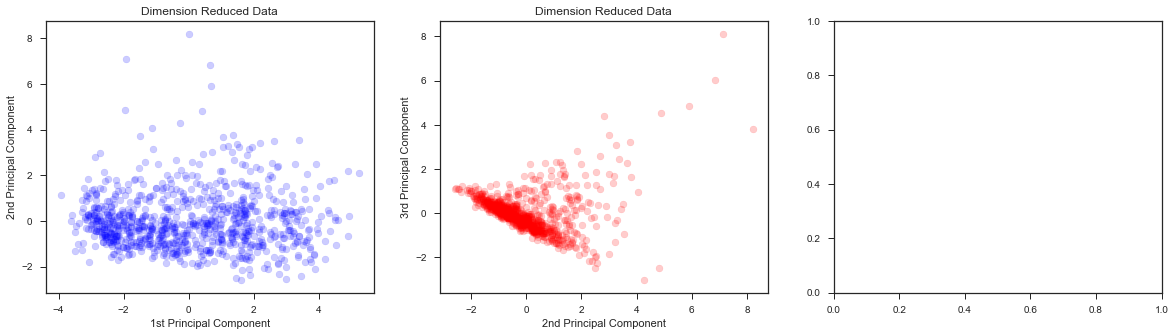

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].scatter(train_pca[:, 0], train_pca[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(train_pca[:, 1], train_pca[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

ax[2].scatter(train_pca[:, 2], train_pca[:, 3], color='green', alpha=0.2, label='train R^2')

ax[2].set_title('Dimension Reduced Data')
ax[2].set_xlabel('3rd Principal Component')
ax[2].set_ylabel('4th Principal Component')

plt.show()

In [113]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(train_pca, y_train)

print('Test R^2: {}'.format(regression_model.score(test_pca, y_test)))

Test R^2: 0.4060320729673273


In [114]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_np, y_train)

print('Test R^2: {}'.format(regression_model.score(X_test_np, y_test)))

Test R^2: 0.40645568346387384


## 3) Now to look at the interactions terms 

In [116]:
gen_poly_terms = PolynomialFeatures(degree=4, interaction_only=False)

min_max_scaler = MinMaxScaler()
X_train_np = min_max_scaler.fit_transform(X_train_np)
X_test_np = min_max_scaler.fit_transform(X_test_np)

X_train_full_poly = gen_poly_terms.fit_transform(X_train_np)
X_test_full_poly = gen_poly_terms.fit_transform(X_test_np)

print('number of total predictors', X_train_full_poly.shape[1])

number of total predictors 52360


In [121]:
pca = PCA(n_components=15)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.11577157  0.06814241  0.05607394  0.04537065  0.04051675  0.0389269
  0.03622823  0.02915125  0.02447893  0.02423241  0.02383276  0.02325903
  0.02253622  0.01735412  0.01674484]


In [122]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_train)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.2594647824838099


In [123]:
pca = PCA(n_components=45)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.11577157  0.06814241  0.05607394  0.04537065  0.04051675  0.0389269
  0.03622823  0.02915125  0.02447893  0.02423241  0.02383277  0.02325903
  0.02253625  0.01735414  0.01674492  0.01475451  0.01442648  0.01304387
  0.01197604  0.01122059  0.01024944  0.00982345  0.00949853  0.00867306
  0.00750947  0.00707672  0.00675862  0.00666869  0.00653244  0.00641926
  0.00622978  0.00595118  0.00588676  0.00558606  0.00553315  0.00543103
  0.00541686  0.00511123  0.00492043  0.00468201  0.00457612  0.00443328
  0.00432961  0.00420883  0.0040865 ]


In [124]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_train)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.327643051134937


In [128]:
y_train

array([-0.49548032, -1.09919735,  0.2671096 ,  0.39420792,  0.99792494,
       -0.55902948,  1.34744532, -0.78145154, -0.81322612,  0.7437283 ,
       -1.09919735,  1.12502326, -0.08241078,  0.52130624,  0.29888418,
        0.23533502,  0.29888418,  0.1082367 , -1.06742276, -1.67113979,
        0.1082367 , -0.46370574, -0.27305826, -0.43193116, -0.14595994,
       -0.5272549 ,  0.23533502, -0.08241078, -0.30483284,  0.4259825 ,
       -0.33660742,  0.80727746,  1.44276906,  0.4259825 , -1.32161941,
        0.48953166, -0.94032444, -0.368382  , -0.30483284,  0.20356044,
       -0.01886162,  0.80727746, -0.17773452, -0.65435322, -2.08420933,
        0.48953166,  0.45775708, -1.95711101, -1.63936521, -2.87857383,
        0.55308082, -0.90854986, -0.87677528,  0.01291296, -0.11418536,
        1.76051486,  1.25212158, -0.90854986, -0.01886162,  0.29888418,
        0.20356044,  1.09324868,  0.52130624, -0.17773452, -0.40015658,
        0.1082367 ,  1.44276906, -0.14595994,  0.33065876,  0.96

In [129]:
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5)

x_val_scores = []

for n in range(1, 80, 5):
    out = n * 1. / 80 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    
    pca = PCA(n_components=15)
    pca.fit(X_train_full_poly)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_train_pca):
        X_train, X_val = X_train_full_poly[train_index], X_train_full_poly[val_index]
        y_train2, y_val = y_train[train_index], y_train[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        regression_model.fit(X_train_pca, y_train2)
        validation_R_sqs.append(regression_model.score(X_val_pca, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))
    
sys.stdout.write("\r%d%%" % 100)

100%

In [132]:
x_val_scores

[-0.028376087476532041,
 -0.03364740319112762,
 -0.024791326787942512,
 -0.037915343692843349,
 -0.077015989227043627,
 -0.11117031209628707,
 -0.17559245032042387,
 -0.28131406252682073,
 -0.29962435074685401,
 -0.65216742172934716,
 -0.37290649892446187,
 -0.26401075667698953,
 -1.5204128177378973,
 -1.0301928954456365,
 -26.545314437908722,
 -93.474214197295154]

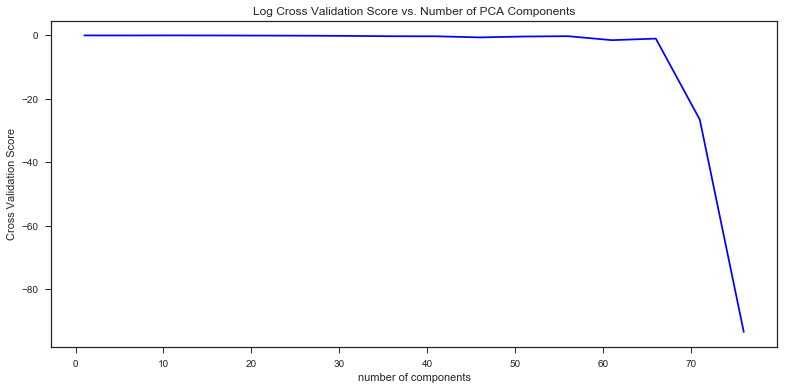

In [133]:
fig, ax = plt.subplots(1, 1)

ax.plot(range(1, 80, 5), x_val_scores, color='blue')

ax.set_title('Cross Validation Score vs. Number of PCA Components')
ax.set_xlabel('number of components')
ax.set_ylabel('Cross Validation Score')

plt.show()

In [134]:
best_n = range(1, 80, 5)[np.argmax(x_val_scores)]

pca = PCA(n_components=best_n)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

regression_model.fit(X_train_pca, y_train)
test_R_sq = regression_model.score(X_test_pca, y_test)

print('best regularization param is:', best_n)
print('the test R^2 for PC regression with n = {} is: {}'.format(best_n, test_R_sq))

ValueError: Found input variables with inconsistent numbers of samples: [876, 700]

## Part (h) 